In [1]:
from awloss import AWLoss

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize, Grayscale
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

%autoreload 2
import sys
sys.path.append('../') 
from networks import *
from utils import *
from landscape import *
from datasets import *
from train_utils import *

import json
import pathlib
import matplotlib.pyplot as plt

## Training Setup

In [12]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
np.random.seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

# Set training static parameters and hyperparameters
nepochs = 5
latent_size = 128                            
learning_rate = 1e-9
batch_size = 512                                        
device = set_device("cuda", 0)
valid_ratio = 0.2
logf = int(nepochs//5) + 1
sampling = .2

No GPU available! Running on CPU


## Datasets and Dataloaders

Total: 40518
    Training images: 32415 
    Validation Images: 8103


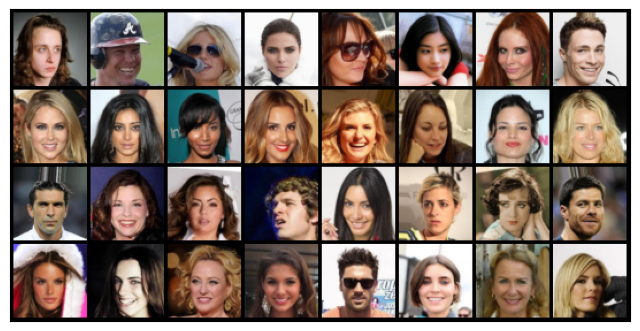

torch.Size([32, 3, 64, 64]) 0.0 1.0


In [3]:
# Datasets and dataloaders
img_dim = 64
dataset = ImageFolder(root="../../data/CelebA/",
                      transform=Compose([
                          Resize(img_dim),
                          CenterCrop(img_dim),
                          ToTensor()
                       ]))

# Train / validation split
idxs = np.arange(0, len(dataset), 1)
np.random.shuffle(idxs)
train_idxs, valid_idxs = (idxs[:int(len(dataset) * (1 - valid_ratio) * sampling)],
                         idxs[-int(len(dataset) * valid_ratio * sampling):])
trainds, validds = (Subset(dataset, train_idxs), 
                    Subset(dataset, valid_idxs))
print(f"Total: {len(trainds) + len(validds)}")
print("    Training images: {} \n    Validation Images: {}".format(len(trainds), len(validds)))

# Dataloaders
train_loader = DataLoader(trainds, batch_size=batch_size, 
                          shuffle=True, num_workers=4)
valid_loader = DataLoader(validds, batch_size=batch_size, 
                          shuffle=False, num_workers=4)

# Visualise batch
sample_batch = next(iter(train_loader))[0][:32]
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(make_grid(sample_batch, pad_value=0, padding=3).numpy(), (1,2,0)))
plt.xticks([]); plt.yticks([])
plt.show()

print(sample_batch.shape, sample_batch.min().item(), sample_batch.max().item())

# Frequency Analysis

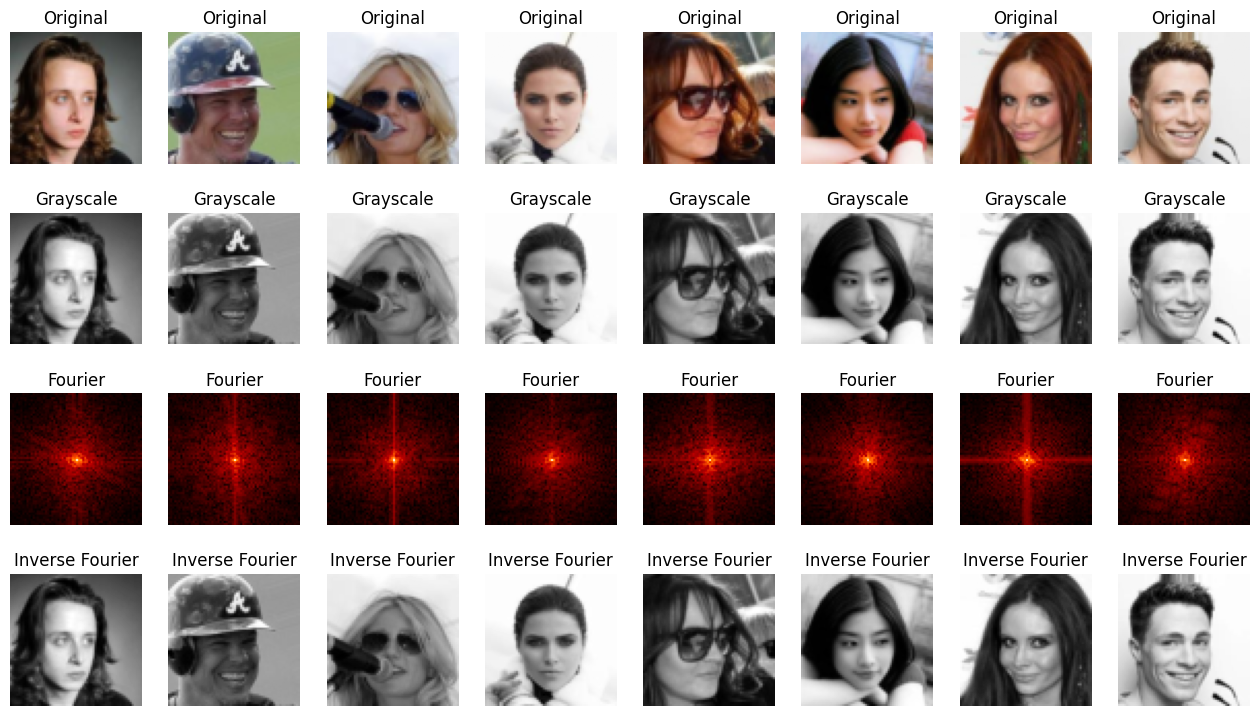

In [4]:
def frequency_analysis(batch, N=10):
    """"""
    # Setup for plot
    fig, axs = plt.subplots(4, N, figsize=(2 * N, 9))

    for i in range(N):
        # Sample one image randomly
        image = batch[i]

        # Original image
        axs[0, i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axs[0, i].set_title("Original", fontdict={'fontsize': 12})

        # Grayscale
        gray_image = Grayscale()(image)
        axs[1, i].imshow(np.transpose(gray_image.numpy(), (1, 2, 0)), cmap="gray")
        axs[1, i].set_title("Grayscale", fontdict={'fontsize': 12})

        # Fourier
        fft = torch.fft.fft2(gray_image)
        fftshifted = torch.fft.fftshift(fft)
        axs[2, i].imshow(np.transpose(torch.log(1 + torch.abs(fftshifted)).numpy(), (1, 2, 0)), cmap="gist_heat")
        axs[2, i].set_title("Fourier", fontdict={'fontsize': 12})

        # Inverse Fourier
        ifftshifted = torch.fft.ifftshift(fftshifted)
        ifft = torch.fft.ifft2(ifftshifted)
        # eps = ((ifft.real - gray_image) ** 2).mean()
        axs[3, i].imshow(np.transpose(ifft.real.numpy(), (1, 2, 0)), cmap="gray")
        # axs[3, i].set_title(f"Inverse Fourier \n (MSE: {eps:.2E})")
        axs[3, i].set_title(f"Inverse Fourier", fontdict={'fontsize': 12})

    # Remove axis
    [axi.set_axis_off() for axi in axs.ravel()]

# Frequency domain analysis
frequency_analysis(sample_batch, N = 8)


## Autoencoder (CNN)

In [5]:
def model_instance():
    model = ResizeConvAE(latent_size=latent_size, 
                        n_channels=sample_batch.shape[1],
                        pre_latent_size=int(img_dim/2/2)).to(device)
    model = nn.DataParallel(model, device_ids=[0, 1])
    return model

model_sample = model_instance()
_ = summary(model=model_sample, input_data=sample_batch[0].shape, verbose=1, depth=3, 
            col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─ResizeConvAE: 1-1                      [-1, 3, 64, 64]           [-1, 3, 64, 64]           --
|    └─Sequential: 2-1                   [-1, 3, 64, 64]           [-1, 128]                 --
|    |    └─Block: 3-1                   [-1, 3, 64, 64]           [-1, 16, 64, 64]          480
|    |    └─MaxPool2d: 3-2               [-1, 16, 64, 64]          [-1, 16, 32, 32]          --
|    |    └─Block: 3-3                   [-1, 16, 32, 32]          [-1, 32, 32, 32]          4,704
|    |    └─MaxPool2d: 3-4               [-1, 32, 32, 32]          [-1, 32, 16, 16]          --
|    |    └─Block: 3-5                   [-1, 32, 16, 16]          [-1, 64, 16, 16]          18,624
|    |    └─Flatten: 3-6                 [-1, 64, 16, 16]          [-1, 16384]               --
|    |    └─Linear: 3-7                  [-1, 16384]               [-1, 128]                 2,097,280
|    └─Sequential: 2

## Training AWLoss 3D

In [6]:
def laplacian3D(mesh):
    alpha, beta = -0.3, 1.5
    xx, yy, zz = mesh[:,:,:,0], mesh[:,:,:,1], mesh[:,:,:,2]
    x = torch.sqrt(xx**2 + yy**2 + zz**2) 
    T = 1 - torch.exp(-torch.abs(x) ** alpha) ** beta
    T = scale2range(T, [0.2, 1.])
    return T

In [7]:
awloss = AWLoss(filter_dim=3,  std=1e-1, epsilon=250., filter_scale=2, 
                reduction="sum", method="fft", store_filters="unorm", penalty_function=laplacian3D)     
                
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, nepochs, eta_min=learning_rate/10)
summary_app = {"latent_size":latent_size,
                "aw_filter_dim": awloss.filter_dim,
                "aw_epsilon":  awloss.epsilon,
                "aw_std": awloss.std,
                "filter_scale": awloss.filter_scale,
                "penalty": awloss.penalty_function.__name__}

In [13]:
train_model(model, optimizer, train_loader, valid_loader, awloss, nepochs=nepochs,
            log_frequency=logf, device=device, gradflow=False, save=True,
            scheduler=scheduler, fcmap="seismic", summary_app=summary_app)

  0% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--



Training started ...


RuntimeError: Function 'PowBackward0' returned nan values in its 0th output.

In [9]:
# Debugging: https://github.com/yenchenlin/nerf-pytorch/issues/38 

# 1st epoch
for _, (X, _) in enumerate(train_loader):
    # Model prediction
    X = X.to(device)
    recon = model(X)

    # Loss eval
    loss = awloss(recon, X)
    print(loss)

    # Loss backward
    loss.backward()

tensor(98.4209, grad_fn=<SumBackward0>)


/opt/homebrew/Caskroom/miniconda/base/envs/awloss/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in PowBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/homebrew/Caskroom/miniconda/base/envs/awloss/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/awloss/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/awloss/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/awloss/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/opt/homebrew/Caskroom/mi

RuntimeError: Function 'PowBackward0' returned nan values in its 0th output.